In [ ]:
import torch
from torch import nn
import torchvision as tv
from torchsummary import summary
import time

In [ ]:
%%capture
!pip install torch_snippets
from torch_snippets import *

## Предобученные архитектуры

In [ ]:
transoforms = tv.transforms.Compose([
    tv.transforms.Grayscale(3),
    tv.transforms.Resize((224, 224)),
    tv.transforms.ToTensor()
])

train_dataset = tv.datasets.EMNIST('./EMNIST', split='balanced', train=True, transform=transoforms, download=True)
test_dataset = tv.datasets.EMNIST('./EMNIST', split='balanced', train=False, transform=transoforms, download=True)
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=32)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=32)

100%|██████████| 561753746/561753746 [00:07<00:00, 78608880.44it/s]


Extracting ./EMNIST/EMNIST/raw/gzip.zip to ./EMNIST/EMNIST/raw


In [ ]:
lst = [k for j,k in test_dataset]
len(set(lst))

47

In [ ]:
for i in train_iter:
  print(i)
  break

In [ ]:
train_dataset[0][0].shape

torch.Size([3, 224, 224])

<function matplotlib.pyplot.show(close=None, block=None)>

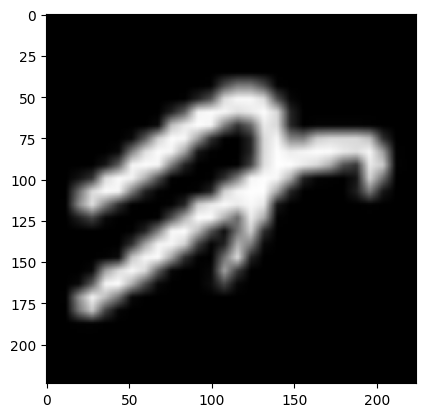

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(train_dataset[4][0].permute(1,2,0))
plt.show

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

#**ResNet18(pretrained=True)**

In [ ]:
%%capture
model = tv.models.resnet18(pretrained=True)

In [ ]:
model

In [ ]:
summary(model.to(device), input_size=(3, 224, 224))

In [ ]:
for name, param in model.named_parameters():
 param.requires_grad = False

In [ ]:
model.layer4

In [ ]:
model.fc

Linear(in_features=512, out_features=1000, bias=True)

In [ ]:
model.fc = nn.Linear(in_features=512, out_features=47)

In [ ]:
model.fc

Linear(in_features=512, out_features=47, bias=True)

In [ ]:
model

In [ ]:
unfreeze_layers = [model.fc]
for layer in unfreeze_layers:
 for param in layer.parameters():
  param.requires_grad = True

In [ ]:
print("Params to learn:")
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:

fc.weight

fc.bias

In [ ]:
trainer = torch.optim.Adam(params_to_update, lr=0.001)

In [ ]:
model.to(device)
loss = nn.CrossEntropyLoss(reduction='mean')
num_epochs = 10
log = Report(num_epochs)
list_1_1 = []
list_1_2 = []
for epoch in range(num_epochs):
    N = len(train_iter)
    for i, (X, y) in enumerate(train_iter):
        model.train()
        if i==N: break
        X, y = X.to(device), y.to(device)
        trainer.zero_grad()
        y_hat = model(X)
        l = loss(y_hat.squeeze(), y)
        l.backward()
        trainer.step()
        train_acc_sum = (y_hat.argmax(axis=1) == y).sum().item()/ len(X)
        log.record(epoch+(i+1)/N, trn_loss=l,trn_acc=train_acc_sum, end='\r')
    list_1_1.append(l)
    N = len(test_iter)
    for i, (X, y) in enumerate(test_iter):
        model.eval()
        if i==N: break
        X, y = X.to(device), y.to(device)
#        with torch.no_grad():
        pred_tarf = model(X)
        l_test = loss(pred_tarf.squeeze(), y)
        test_acc = (model(X).argmax(axis=1) == y).sum()/ len(X)
        log.record(epoch+(i+1)/N, val_loss=l_test, val_acc=test_acc, end='\r')
    list_1_2.append(l_test)
    log.report_avgs(epoch+1)

EPOCH: 1.000  val_acc: 0.785  trn_acc: 0.706  trn_loss: 1.044  val_loss: 0.723  (342.43s - 3081.89s remaining)
EPOCH: 2.000  val_acc: 0.796  trn_acc: 0.780  trn_loss: 0.702  val_loss: 0.663  (680.69s - 2722.74s remaining)
EPOCH: 3.000  val_acc: 0.801  trn_acc: 0.795  trn_loss: 0.646  val_loss: 0.640  (1018.96s - 2377.56s remaining)
EPOCH: 4.000  val_acc: 0.804  trn_acc: 0.803  trn_loss: 0.616  val_loss: 0.629  (1356.43s - 2034.64s remaining)
EPOCH: 5.000  val_acc: 0.806  trn_acc: 0.809  trn_loss: 0.596  val_loss: 0.623  (1694.05s - 1694.05s remaining)
EPOCH: 6.000  val_acc: 0.806  trn_acc: 0.813  trn_loss: 0.581  val_loss: 0.619  (2025.08s - 1350.05s remaining)
EPOCH: 7.000  val_acc: 0.807  trn_acc: 0.816  trn_loss: 0.570  val_loss: 0.616  (2358.22s - 1010.66s remaining)
EPOCH: 8.000  val_acc: 0.808  trn_acc: 0.818  trn_loss: 0.561  val_loss: 0.615  (2692.74s - 673.19s remaining)
EPOCH: 9.000  val_acc: 0.808  trn_acc: 0.821  trn_loss: 0.553  val_loss: 0.614  (3025.47s - 336.16s remaini

In [ ]:
print(list_1_1, list_1_2)

[
    tensor(0.7809, device='cuda:0', grad_fn=<NllLossBackward0>),
    tensor(0.6407, device='cuda:0', grad_fn=<NllLossBackward0>),
    tensor(0.5667, device='cuda:0', grad_fn=<NllLossBackward0>),
    tensor(0.5203, device='cuda:0', grad_fn=<NllLossBackward0>),
    tensor(0.4869, device='cuda:0', grad_fn=<NllLossBackward0>),
    tensor(0.4605, device='cuda:0', grad_fn=<NllLossBackward0>),
    tensor(0.4385, device='cuda:0', grad_fn=<NllLossBackward0>),
    tensor(0.4196, device='cuda:0', grad_fn=<NllLossBackward0>),
    tensor(0.4032, device='cuda:0', grad_fn=<NllLossBackward0>),
    tensor(0.3888, device='cuda:0', grad_fn=<NllLossBackward0>)
]
[
    tensor(0.7871, device='cuda:0', grad_fn=<NllLossBackward0>),
    tensor(0.7850, device='cuda:0', grad_fn=<NllLossBackward0>),
    tensor(0.7949, device='cuda:0', grad_fn=<NllLossBackward0>),
    tensor(0.7961, device='cuda:0', grad_fn=<NllLossBackward0>),
    tensor(0.7910, device='cuda:0', grad_fn=<NllLossBackward0>),
    tensor(0.7825, device='cuda:0', grad_fn=<NllLossBackward0>),
    tensor(0.7724, device='cuda:0', grad_fn=<NllLossBackward0>),
    tensor(0.7619, device='cuda:0', grad_fn=<NllLossBackward0>),
    tensor(0.7516, device='cuda:0', grad_fn=<NllLossBackward0>),
    tensor(0.7418, device='cuda:0', grad_fn=<NllLossBackward0>)
]

In [ ]:
ResNet18_train_loss = [round(float(i),3) for i in list_1_1]
ResNet18_test_loss = [round(float(i),3) for i in list_1_2]
print(ResNet18_train_loss, ResNet18_test_loss)

[0.781, 0.641, 0.567, 0.52, 0.487, 0.461, 0.438, 0.42, 0.403, 0.389]
[0.787, 0.785, 0.795, 0.796, 0.791, 0.782, 0.772, 0.762, 0.752, 0.742]

100%|██████████| 111/111 [00:01<00:00, 100.30it/s]


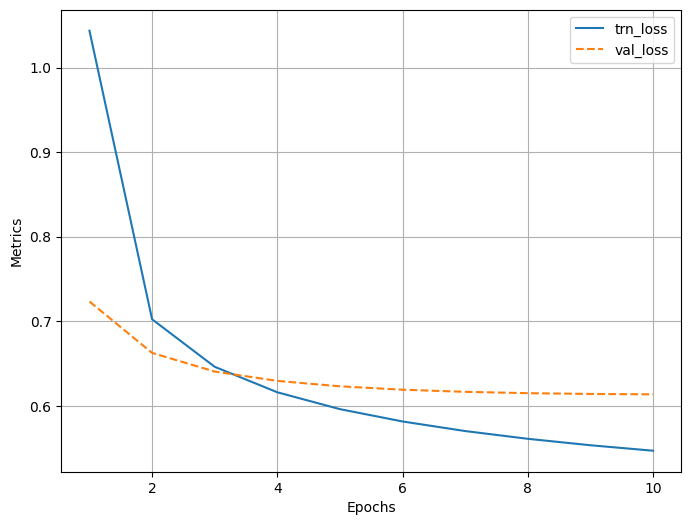

100%|██████████| 111/111 [00:01<00:00, 102.51it/s]


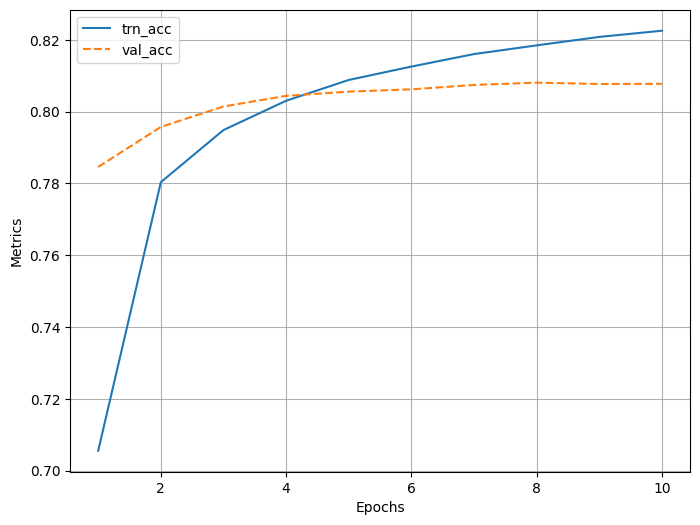

(None, None)

In [ ]:
log.plot_epochs('trn_loss,val_loss'.split(',')), log.plot_epochs('trn_acc,val_acc'.split(','))

#**VGG16(pretrained=True)**

In [ ]:
model = tv.models.vgg16(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 244MB/s]


In [ ]:
model

In [ ]:
summary(model.to(device), input_size=(3, 224, 224))

In [ ]:
for name, param in model.named_parameters():
 param.requires_grad = False

In [ ]:
model.classifier[6]

Linear(in_features=4096, out_features=1000, bias=True)

In [ ]:
model.classifier[6] = nn.Linear(in_features=4096, out_features=47)

In [ ]:
model.classifier[6]

Linear(in_features=4096, out_features=47, bias=True)

In [ ]:
unfreeze_layers = [model.classifier[6]]
for layer in unfreeze_layers:
 for param in layer.parameters():
  param.requires_grad = True

In [ ]:
print("Params to learn:")
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:

classifier.6.weight

classifier.6.bias

In [ ]:
trainer = torch.optim.Adam(params_to_update, lr=0.001)

In [ ]:
#def train(net, train_iter, test_iter, trainer, num_epochs):
model.to(device)
loss = nn.CrossEntropyLoss(reduction='mean')
num_epochs = 10
log = Report(num_epochs)
list_2_1 = []
list_2_2 = []
for epoch in range(num_epochs):
    N = len(train_iter)
    for i, (X, y) in enumerate(train_iter):
        model.train()
        if i==N: break
        X, y = X.to(device), y.to(device)
        trainer.zero_grad()
        y_hat = model(X)
        l = loss(y_hat.squeeze(), y)
        l.backward()
        trainer.step()
        train_acc_sum = (y_hat.argmax(axis=1) == y).sum().item()/ len(X)
        log.record(epoch+(i+1)/N, trn_loss=l,trn_acc=train_acc_sum, end='\r')
    list_2_1.append(l)

    N = len(test_iter)
    for i, (X, y) in enumerate(test_iter):
        model.eval()
        if i==N: break
        X, y = X.to(device), y.to(device)
#        with torch.no_grad():
        pred_tarf = model(X)
        l_test = loss(pred_tarf.squeeze(), y)
        test_acc = (model(X).argmax(axis=1) == y).sum()/ len(X)
        log.record(epoch+(i+1)/N, val_loss=l_test, val_acc=test_acc, end='\r')
    list_2_2.append(l_test)
    log.report_avgs(epoch+1)

EPOCH: 1.000  val_acc: 0.716  trn_loss: 1.450  trn_acc: 0.571  val_loss: 0.944  (909.09s - 8181.79s remaining)
EPOCH: 2.000  val_acc: 0.754  trn_loss: 1.276  trn_acc: 0.619  val_loss: 0.817  (1821.30s - 7285.20s remaining)
EPOCH: 3.000  val_acc: 0.750  trn_loss: 1.258  trn_acc: 0.627  val_loss: 0.808  (2727.61s - 6364.43s remaining)
EPOCH: 4.000  val_acc: 0.761  trn_loss: 1.247  trn_acc: 0.632  val_loss: 0.781  (3633.40s - 5450.10s remaining)
EPOCH: 5.000  val_acc: 0.762  trn_loss: 1.249  trn_acc: 0.635  val_loss: 0.769  (4544.12s - 4544.12s remaining)
EPOCH: 6.000  val_acc: 0.763  trn_loss: 1.241  trn_acc: 0.638  val_loss: 0.761  (5457.10s - 3638.07s remaining)
EPOCH: 7.000  val_acc: 0.759  trn_loss: 1.250  trn_acc: 0.638  val_loss: 0.770  (6366.78s - 2728.62s remaining)
EPOCH: 8.000  val_acc: 0.767  trn_loss: 1.247  trn_acc: 0.640  val_loss: 0.750  (7280.01s - 1820.00s remaining)
EPOCH: 9.000  val_acc: 0.757  trn_loss: 1.244  trn_acc: 0.642  val_loss: 0.777  (8201.23s - 911.25s remai

In [ ]:
print(list_2_1, list_2_2)

[
    tensor(1.0283, device='cuda:0', grad_fn=<NllLossBackward0>),
    tensor(1.4423, device='cuda:0', grad_fn=<NllLossBackward0>),
    tensor(1.4462, device='cuda:0', grad_fn=<NllLossBackward0>),
    tensor(1.2554, device='cuda:0', grad_fn=<NllLossBackward0>),
    tensor(1.4502, device='cuda:0', grad_fn=<NllLossBackward0>),
    tensor(1.6416, device='cuda:0', grad_fn=<NllLossBackward0>),
    tensor(1.8156, device='cuda:0', grad_fn=<NllLossBackward0>),
    tensor(1.5628, device='cuda:0', grad_fn=<NllLossBackward0>),
    tensor(0.9307, device='cuda:0', grad_fn=<NllLossBackward0>),
    tensor(1.1762, device='cuda:0', grad_fn=<NllLossBackward0>)
]
[
    tensor(1.1677, device='cuda:0', grad_fn=<NllLossBackward0>),
    tensor(1.1133, device='cuda:0', grad_fn=<NllLossBackward0>),
    tensor(1.0153, device='cuda:0', grad_fn=<NllLossBackward0>),
    tensor(0.9141, device='cuda:0', grad_fn=<NllLossBackward0>),
    tensor(0.9916, device='cuda:0', grad_fn=<NllLossBackward0>),
    tensor(0.8538, device='cuda:0', grad_fn=<NllLossBackward0>),
    tensor(0.8080, device='cuda:0', grad_fn=<NllLossBackward0>),
    tensor(0.8732, device='cuda:0', grad_fn=<NllLossBackward0>),
    tensor(1.1541, device='cuda:0', grad_fn=<NllLossBackward0>),
    tensor(1.0188, device='cuda:0', grad_fn=<NllLossBackward0>)
]

In [ ]:
VGG16_train_loss = [round(float(i),3) for i in list_2_1]
VGG16_test_loss = [round(float(i),3) for i in list_2_2]
print(VGG16_train_loss, VGG16_test_loss)

[1.028, 1.442, 1.446, 1.255, 1.45, 1.642, 1.816, 1.563, 0.931, 1.176]
[1.168, 1.113, 1.015, 0.914, 0.992, 0.854, 0.808, 0.873, 1.154, 1.019]

100%|██████████| 111/111 [00:01<00:00, 76.04it/s]


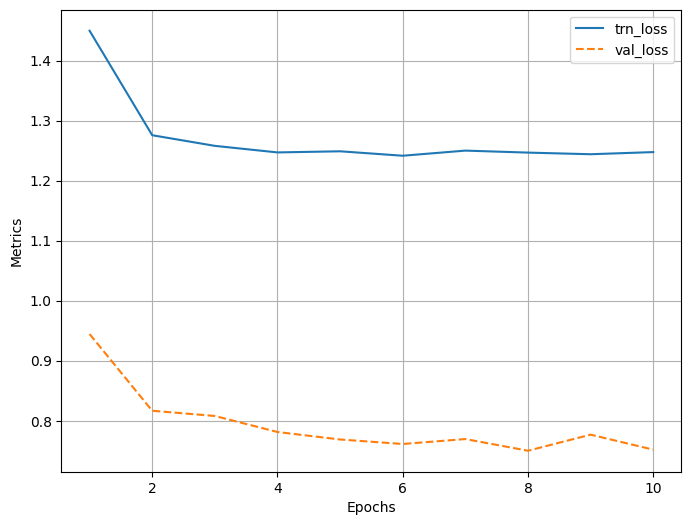

100%|██████████| 111/111 [00:01<00:00, 79.58it/s]


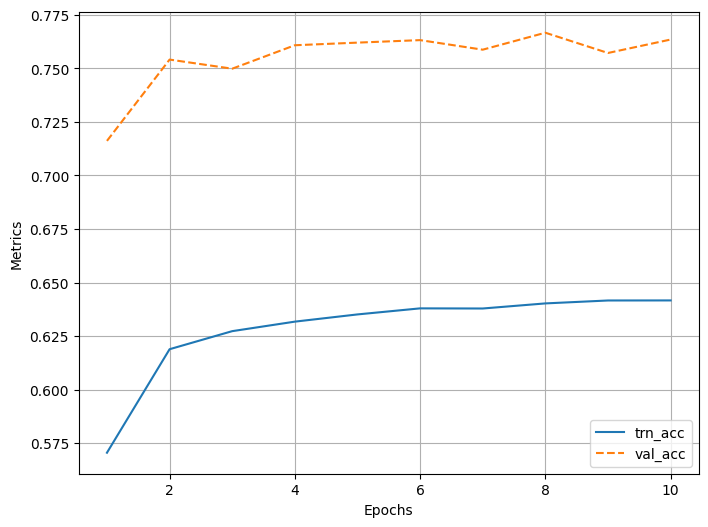

(None, None)

In [ ]:
log.plot_epochs('trn_loss,val_loss'.split(',')), log.plot_epochs('trn_acc,val_acc'.split(','))

#**Inception v3(pretrained=True)**

In [ ]:
transoforms = tv.transforms.Compose([
    transforms.Grayscale(3),
    transforms.Resize(299),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
transoforms = tv.transforms.Compose([
    tv.transforms.Grayscale(3),
    tv.transforms.Resize((299, 299)),
    tv.transforms.ToTensor()
])

In [ ]:
train_dataset = tv.datasets.EMNIST('./EMNIST', split='balanced', train=True, transform=transoforms, download=True)
test_dataset = tv.datasets.EMNIST('./EMNIST', split='balanced', train=False, transform=transoforms, download=True)
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=32)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=32)

<function matplotlib.pyplot.show(close=None, block=None)>

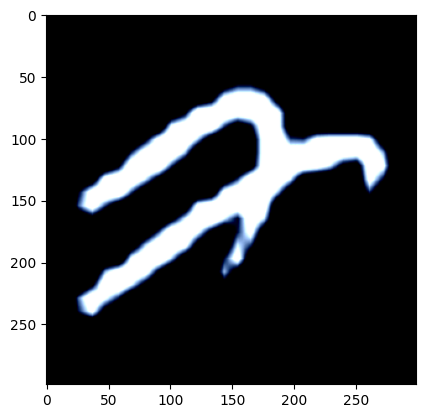

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(train_dataset[4][0].permute(1,2,0))
plt.show

In [ ]:
%%capture
model = tv.models.inception_v3(pretrained=True)

In [ ]:
model

In [ ]:
model.Mixed_7c

In [ ]:
summary(model.to(device), input_size=(3, 299, 299))

In [ ]:
for name, param in model.named_parameters():
 param.requires_grad = False

In [ ]:
model.fc

Linear(in_features=2048, out_features=1000, bias=True)

In [ ]:
model.fc = nn.Linear(in_features=2048, out_features=47)

In [ ]:
model.fc

Linear(in_features=2048, out_features=47, bias=True)

In [ ]:
model

In [ ]:
unfreeze_layers = [model.Mixed_7c, model.fc]
for layer in unfreeze_layers:
 for param in layer.parameters():
  param.requires_grad = True

In [ ]:
print("Params to learn:")
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:

Mixed_7c.branch1x1.conv.weight

Mixed_7c.branch1x1.bn.weight

Mixed_7c.branch1x1.bn.bias

Mixed_7c.branch3x3_1.conv.weight

Mixed_7c.branch3x3_1.bn.weight

Mixed_7c.branch3x3_1.bn.bias

Mixed_7c.branch3x3_2a.conv.weight

Mixed_7c.branch3x3_2a.bn.weight

Mixed_7c.branch3x3_2a.bn.bias

Mixed_7c.branch3x3_2b.conv.weight

Mixed_7c.branch3x3_2b.bn.weight

Mixed_7c.branch3x3_2b.bn.bias

Mixed_7c.branch3x3dbl_1.conv.weight

Mixed_7c.branch3x3dbl_1.bn.weight

Mixed_7c.branch3x3dbl_1.bn.bias

Mixed_7c.branch3x3dbl_2.conv.weight

Mixed_7c.branch3x3dbl_2.bn.weight

Mixed_7c.branch3x3dbl_2.bn.bias

Mixed_7c.branch3x3dbl_3a.conv.weight

Mixed_7c.branch3x3dbl_3a.bn.weight

Mixed_7c.branch3x3dbl_3a.bn.bias

Mixed_7c.branch3x3dbl_3b.conv.weight

Mixed_7c.branch3x3dbl_3b.bn.weight

Mixed_7c.branch3x3dbl_3b.bn.bias

Mixed_7c.branch_pool.conv.weight

Mixed_7c.branch_pool.bn.weight

Mixed_7c.branch_pool.bn.bias

fc.weight

fc.bias

In [ ]:
trainer = torch.optim.Adam(params_to_update, lr=0.001)

In [ ]:
model.to(device)
loss = nn.CrossEntropyLoss(reduction='mean')
num_epochs = 10
log = Report(num_epochs)
list_3_1 = []
list_3_2 = []
for epoch in range(num_epochs):
    N = len(train_iter)
    for i, (X, y) in enumerate(train_iter):
        model.train()
        if i==N: break
        X, y = X.to(device), y.to(device)
        trainer.zero_grad()
        y_hat,_ = model(X)
        l = loss(y_hat.squeeze(), y)
#        print(y_hat)
        # print(aux.squeeze())
#        print(y)
        # loss1 = loss(y_hat, y)
        # loss2 = loss(y_hat, y)
        # loss = loss1 + 0.4*loss2
        # l = loss1 + 0.4*loss2
        l.backward()
        trainer.step()
        train_acc_sum = (y_hat.argmax(axis=1) == y).sum().item()/ len(X)
        log.record(epoch+(i+1)/N, trn_loss=l,trn_acc=train_acc_sum, end='\r')
    list_3_1.append(l)
    N = len(test_iter)
    for i, (X, y) in enumerate(test_iter):
        model.eval()
        if i==N: break
        X, y = X.to(device), y.to(device)
#        with torch.no_grad():
        pred_tarf = model(X)
        l_test = loss(pred_tarf.squeeze(), y)
        test_acc = (model(X).argmax(axis=1) == y).sum()/ len(X)
        log.record(epoch+(i+1)/N, val_loss=l_test, val_acc=test_acc, end='\r')
    list_3_2.append(l_test)
    log.report_avgs(epoch+1)

EPOCH: 1.000  trn_loss: 0.579  val_loss: 0.403  val_acc: 0.864  trn_acc: 0.811  (1086.66s - 9779.96s remaining)
EPOCH: 2.000  trn_loss: 0.349  val_loss: 0.418  val_acc: 0.865  trn_acc: 0.876  (2166.26s - 8665.04s remaining)
EPOCH: 3.000  trn_loss: 0.240  val_loss: 0.481  val_acc: 0.863  trn_acc: 0.909  (3245.24s - 7572.24s remaining)
EPOCH: 4.000  trn_loss: 0.164  val_loss: 0.556  val_acc: 0.859  trn_acc: 0.936  (4316.54s - 6474.81s remaining)
EPOCH: 5.000  trn_loss: 0.111  val_loss: 0.655  val_acc: 0.858  trn_acc: 0.958  (5381.64s - 5381.64s remaining)
EPOCH: 6.000  trn_loss: 0.082  val_loss: 0.713  val_acc: 0.862  trn_acc: 0.970  (6454.36s - 4302.91s remaining)
EPOCH: 7.000  trn_loss: 0.065  val_loss: 0.806  val_acc: 0.861  trn_acc: 0.977  (7512.58s - 3219.68s remaining)
EPOCH: 8.000  trn_loss: 0.054  val_loss: 0.848  val_acc: 0.862  trn_acc: 0.981  (8586.56s - 2146.64s remaining)
EPOCH: 9.000  trn_loss: 0.046  val_loss: 0.855  val_acc: 0.860  trn_acc: 0.984  (9631.37s - 1070.15s rem

In [ ]:
Inception_train_loss = [round(float(i),3) for i in list_3_1]
Inception_test_loss = [round(float(i),3) for i in list_3_2]
print(Inception_train_loss, Inception_test_loss)

[0.386, 0.445, 0.194, 0.216, 0.062, 0.116, 0.022, 0.129, 0.034, 0.009]
[0.497, 0.481, 0.452, 0.726, 0.799, 0.28, 1.144, 1.058, 1.549, 1.605]

In [ ]:
print(list_3_1, list_3_2)

[
    tensor(0.3858, device='cuda:0', grad_fn=<NllLossBackward0>),
    tensor(0.4447, device='cuda:0', grad_fn=<NllLossBackward0>),
    tensor(0.1944, device='cuda:0', grad_fn=<NllLossBackward0>),
    tensor(0.2160, device='cuda:0', grad_fn=<NllLossBackward0>),
    tensor(0.0616, device='cuda:0', grad_fn=<NllLossBackward0>),
    tensor(0.1161, device='cuda:0', grad_fn=<NllLossBackward0>),
    tensor(0.0224, device='cuda:0', grad_fn=<NllLossBackward0>),
    tensor(0.1290, device='cuda:0', grad_fn=<NllLossBackward0>),
    tensor(0.0341, device='cuda:0', grad_fn=<NllLossBackward0>),
    tensor(0.0092, device='cuda:0', grad_fn=<NllLossBackward0>)
]
[
    tensor(0.4971, device='cuda:0', grad_fn=<NllLossBackward0>),
    tensor(0.4809, device='cuda:0', grad_fn=<NllLossBackward0>),
    tensor(0.4524, device='cuda:0', grad_fn=<NllLossBackward0>),
    tensor(0.7263, device='cuda:0', grad_fn=<NllLossBackward0>),
    tensor(0.7989, device='cuda:0', grad_fn=<NllLossBackward0>),
    tensor(0.2804, device='cuda:0', grad_fn=<NllLossBackward0>),
    tensor(1.1437, device='cuda:0', grad_fn=<NllLossBackward0>),
    tensor(1.0575, device='cuda:0', grad_fn=<NllLossBackward0>),
    tensor(1.5487, device='cuda:0', grad_fn=<NllLossBackward0>),
    tensor(1.6052, device='cuda:0', grad_fn=<NllLossBackward0>)
]

100%|██████████| 111/111 [00:01<00:00, 74.23it/s]


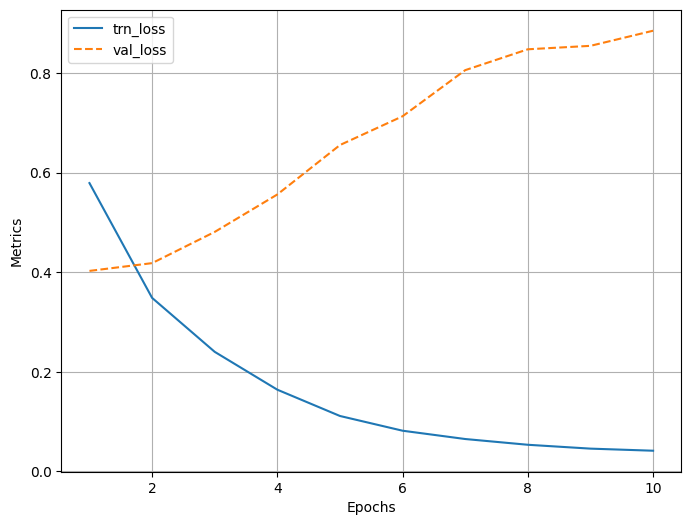

100%|██████████| 111/111 [00:01<00:00, 76.36it/s]


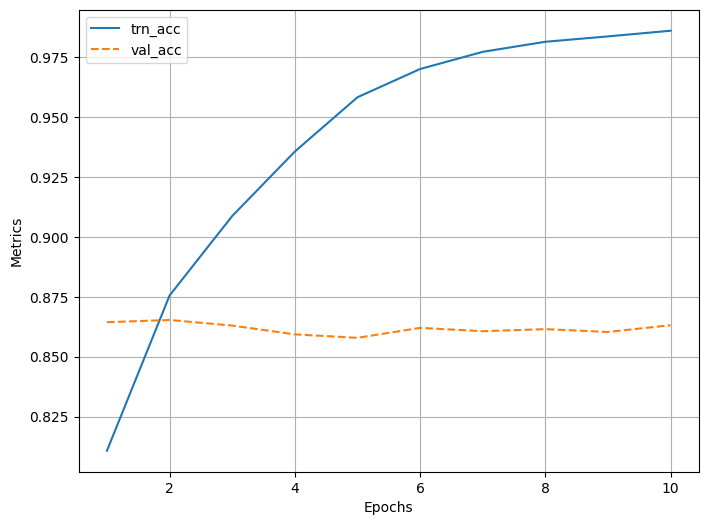

(None, None)

In [ ]:
log.plot_epochs('trn_loss,val_loss'.split(',')), log.plot_epochs('trn_acc,val_acc'.split(','))

#**DenseNet 161(pretrained=True)**

In [ ]:
transoforms = tv.transforms.Compose([
    tv.transforms.Grayscale(3),
    tv.transforms.Resize((224, 224)),
    tv.transforms.ToTensor()
])

train_dataset = tv.datasets.EMNIST('./EMNIST', split='balanced', train=True, transform=transoforms, download=True)
test_dataset = tv.datasets.EMNIST('./EMNIST', split='balanced', train=False, transform=transoforms, download=True)
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=32)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=32)

100%|██████████| 561753746/561753746 [00:06<00:00, 89218167.81it/s]


Extracting ./EMNIST/EMNIST/raw/gzip.zip to ./EMNIST/EMNIST/raw


In [ ]:
%%capture
model = tv.models.densenet161(pretrained=True)

In [ ]:
model

In [ ]:
for name, param in model.named_parameters():
 param.requires_grad = False

In [ ]:
model.classifier

Linear(in_features=2208, out_features=1000, bias=True)

In [ ]:
model.classifier = nn.Linear(in_features=2208, out_features=47)

In [ ]:
model.classifier

Linear(in_features=2208, out_features=47, bias=True)

In [ ]:
model

In [ ]:
unfreeze_layers = [model.classifier]
for layer in unfreeze_layers:
 for param in layer.parameters():
  param.requires_grad = True

In [ ]:
print("Params to learn:")
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:

classifier.weight

classifier.bias

In [ ]:
trainer = torch.optim.Adam(params_to_update, lr=0.001)

In [ ]:
model.to(device)
loss = nn.CrossEntropyLoss(reduction='mean')
num_epochs = 10
log = Report(num_epochs)
list_4_1 = []
list_4_2 = []
for epoch in range(num_epochs):
    N = len(train_iter)
    for i, (X, y) in enumerate(train_iter):
        model.train()
        if i==N: break
        X, y = X.to(device), y.to(device)
        trainer.zero_grad()
        y_hat = model(X)
        l = loss(y_hat.squeeze(), y)
        l.backward()
        trainer.step()
        train_acc_sum = (y_hat.argmax(axis=1) == y).sum().item()/ len(X)
        log.record(epoch+(i+1)/N, trn_loss=l,trn_acc=train_acc_sum, end='\r')
    list_4_1.append(l)
    N = len(test_iter)
    for i, (X, y) in enumerate(test_iter):
        model.eval()
        if i==N: break
        X, y = X.to(device), y.to(device)
#        with torch.no_grad():
        pred_tarf = model(X)
        l_test = loss(pred_tarf.squeeze(), y)
        test_acc = (model(X).argmax(axis=1) == y).sum()/ len(X)
        log.record(epoch+(i+1)/N, val_loss=l_test, val_acc=test_acc, end='\r')
    list_4_2.append(l_test)
    log.report_avgs(epoch+1)

EPOCH: 1.000  trn_acc: 0.704  val_acc: 0.779  val_loss: 0.723  trn_loss: 1.039  (1330.63s - 11975.63s remaining)
EPOCH: 2.000  trn_acc: 0.787  val_acc: 0.793  val_loss: 0.670  trn_loss: 0.680  (2653.96s - 10615.82s remaining)
EPOCH: 3.000  trn_acc: 0.805  val_acc: 0.797  val_loss: 0.657  trn_loss: 0.613  (3976.04s - 9277.42s remaining)
EPOCH: 4.000  trn_acc: 0.815  val_acc: 0.799  val_loss: 0.656  trn_loss: 0.577  (5300.59s - 7950.89s remaining)
EPOCH: 5.000  trn_acc: 0.822  val_acc: 0.798  val_loss: 0.660  trn_loss: 0.553  (6621.03s - 6621.03s remaining)
EPOCH: 6.000  trn_acc: 0.828  val_acc: 0.797  val_loss: 0.666  trn_loss: 0.535  (7938.41s - 5292.27s remaining)
EPOCH: 7.000  trn_acc: 0.832  val_acc: 0.798  val_loss: 0.672  trn_loss: 0.522  (9257.08s - 3967.32s remaining)
EPOCH: 8.000  trn_acc: 0.835  val_acc: 0.797  val_loss: 0.679  trn_loss: 0.511  (10580.14s - 2645.03s remaining)
EPOCH: 9.000  trn_acc: 0.838  val_acc: 0.797  val_loss: 0.687  trn_loss: 0.503  (11900.40s - 1322.27s

In [ ]:
Inception_train_loss = [round(float(i),3) for i in list_4_1]
Inception_test_loss = [round(float(i),3) for i in list_4_2]
print(Inception_train_loss, Inception_test_loss)

In [ ]:
list_4_2 = [0.723, 0.670, 0.657, 0.656, 0.660, 0.666, 0.672, 0.679, 0.687, 0.697]

In [ ]:
np.arange(0,10)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

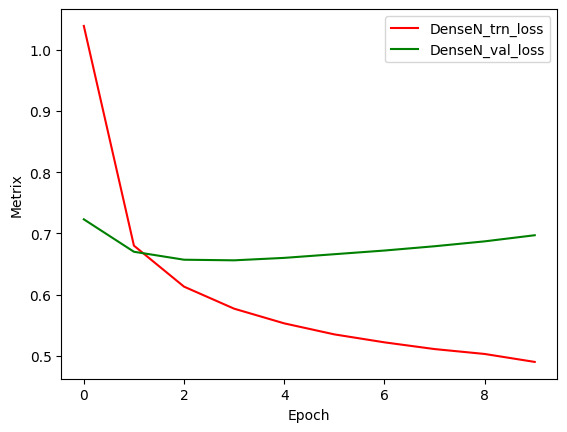

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import math

X = np.arange(0,10)

y = list_4_1
z = list_4_2

# Plotting both the curves simultaneously
plt.plot(X, y, color='r', label='DenseN_trn_loss')
plt.plot(X, z, color='g', label='DenseN_val_loss')

# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Epoch")
plt.ylabel("Metrix")

# Adding legend, which helps us recognize the curve according to it's color
plt.legend()

# To load the display window
plt.show()


In [ ]:
log.plot_epochs('trn_loss,val_loss'.split(',')), log.plot_epochs('trn_acc,val_acc'.split(','))

In [ ]:
#ResNet18
list_1_1 = [0.781, 0.641, 0.567, 0.52, 0.487, 0.461, 0.438, 0.42, 0.403, 0.389]
list_1_2 = [0.787, 0.785, 0.795, 0.796, 0.791, 0.782, 0.772, 0.762, 0.752, 0.742]
#VGG16
list_2_1 = [1.028, 1.442, 1.446, 1.255, 1.45, 1.642, 1.816, 1.563, 0.931, 1.176]
list_2_2 = [1.168, 1.113, 1.015, 0.914, 0.992, 0.854, 0.808, 0.873, 1.154, 1.019]
#Inception v3
list_3_1 = [0.386, 0.445, 0.194, 0.216, 0.062, 0.116, 0.022, 0.129, 0.034, 0.009]
list_3_2 = [0.497, 0.481, 0.452, 0.726, 0.799, 0.28, 1.144, 1.058, 1.549, 1.605]
#DenseNet 161
list_4_1 = [1.039, 0.680, 0.613, 0.577, 0.553, 0.535, 0.522, 0.511, 0.503, 0.49]
list_4_2 = [0.723, 0.670, 0.657, 0.656, 0.660, 0.666, 0.672, 0.679, 0.687, 0.697]

In [ ]:
# tab:blue
# tab:orange
# tab:green
# tab:red
# tab:purple
# tab:brown
# tab:pink
# tab:gray
# tab:olive
# tab:cyan

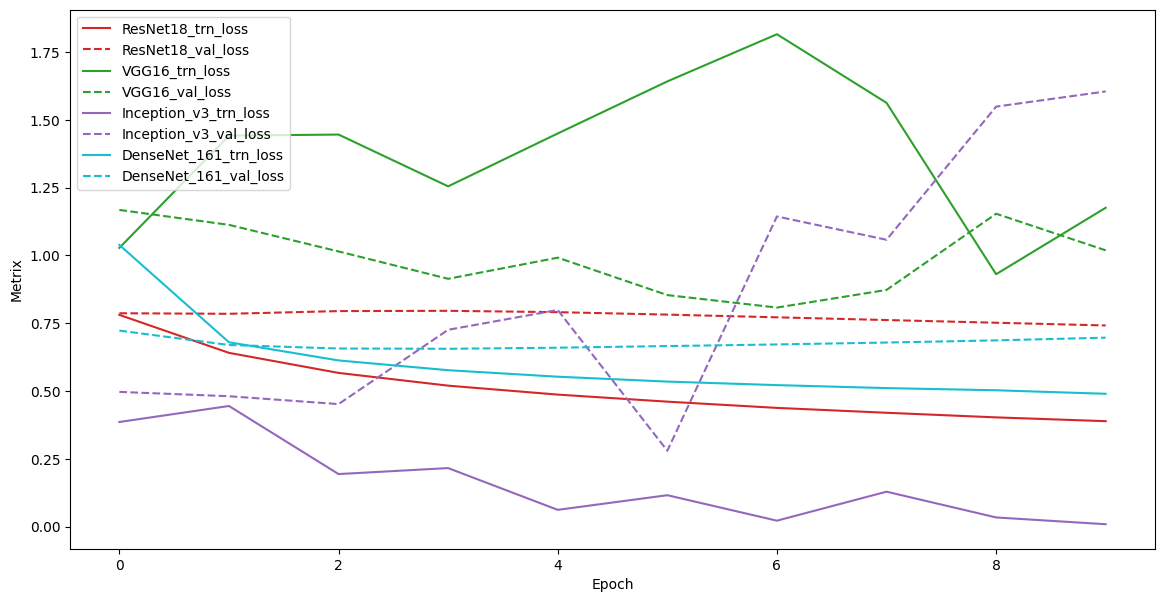

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import math
plt.figure(figsize=(14,7))
X = np.arange(0,10)

# Plotting both the curves simultaneously
plt.plot(X, list_1_1, color='tab:red', label='ResNet18_trn_loss')
plt.plot(X, list_1_2, color='tab:red', linestyle='dashed', label='ResNet18_val_loss')

plt.plot(X, list_2_1, color='tab:green', label='VGG16_trn_loss')
plt.plot(X, list_2_2, color='tab:green', linestyle='dashed', label='VGG16_val_loss')

plt.plot(X, list_3_1, color='tab:purple', label='Inception_v3_trn_loss')
plt.plot(X, list_3_2, color='tab:purple', linestyle='dashed', label='Inception_v3_val_loss')

plt.plot(X, list_4_1, color='tab:cyan', label='DenseNet_161_trn_loss')
plt.plot(X, list_4_2, color='tab:cyan', linestyle='dashed', label='DenseNet_161_val_loss')

# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Epoch")
plt.ylabel("Metrix")

# Adding legend, which helps us recognize the curve according to it's color
plt.legend()

# To load the display window
plt.show()



---



#**Задание со звездочкой***

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"kostyasereginmailru","key":"ad05ad97cdde449caa2e57874c5b2819"}'}

In [ ]:
!ls -lha kaggle.json

-rw-r--r-- 1 root root 75 Jul  9 17:38 kaggle.json


In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d ajayrana/hymenoptera-data

hymenoptera-data.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip -qq /content/hymenoptera-data.zip

In [ ]:
import torchvision
import torch.nn as nn
import torch
import torch.nn.functional as F
from torchvision import transforms,models,datasets
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from torch import optim
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import cv2, glob, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

In [ ]:
train_data_dir = '/content/hymenoptera_data/train'
test_data_dir = '/content/hymenoptera_data/val'

In [ ]:
class AntsBees(Dataset):
    def __init__(self, folder):
        ants = glob(folder+'/ants/*.jpg')
        bees = glob(folder+'/bees/*.jpg')
        self.fpaths = ants + bees
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
        from random import shuffle, seed; seed(10); shuffle(self.fpaths)
        self.targets = [fpath.split('/')[-2].startswith('bees') for fpath in self.fpaths]
    def __len__(self): return len(self.fpaths)
    def __getitem__(self, ix):
        f = self.fpaths[ix]
        target = self.targets[ix]
        im = (cv2.imread(f)[:,:,::-1])
        im = cv2.resize(im, (224,224))
        im = torch.tensor(im/255)
        im = im.permute(2,0,1)
        im = self.normalize(im)
        return im.float().to(device), torch.tensor([target]).float().to(device)

In [ ]:
def get_data():
    train = AntsBees(train_data_dir)
    trn_dl = DataLoader(train, batch_size=32, shuffle=True, drop_last = True)
    val = AntsBees(test_data_dir)
    val_dl = DataLoader(val, batch_size=32, shuffle=True, drop_last = True)
    return trn_dl, val_dl

In [ ]:
trn_dl, val_dl = get_data()

In [ ]:
for i in trn_dl:
  print(i)

In [ ]:
data = AntsBees(train_data_dir)

tensor([0.])

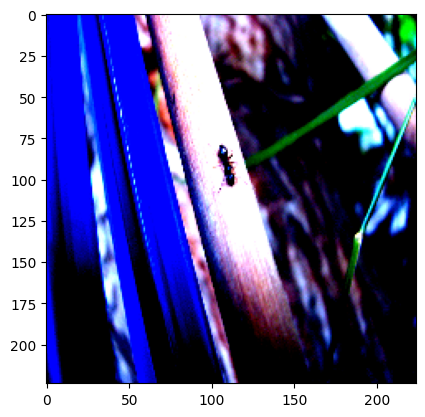

In [ ]:
im, label = data[54]
plt.imshow(im.permute(1,2,0).cpu())
print(label)

In [ ]:
%%capture
model = tv.models.resnet18(pretrained=True)

In [ ]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
summary(model.to(device), input_size=(3, 224, 224))

In [ ]:
for name, param in model.named_parameters():
 param.requires_grad = False

In [ ]:
model.layer4

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential(
      (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): BasicBlock(
    (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1

In [ ]:
model.fc

Linear(in_features=512, out_features=1000, bias=True)

In [ ]:
model.fc = nn.Linear(in_features=512, out_features=47)

In [ ]:
model.fc

Linear(in_features=512, out_features=47, bias=True)

In [ ]:
model

In [ ]:
unfreeze_layers = [model.layer4, model.fc]
for layer in unfreeze_layers:
 for param in layer.parameters():
  param.requires_grad = True

In [ ]:
print("Params to learn:")
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:

layer4.0.conv1.weight

layer4.0.bn1.weight

layer4.0.bn1.bias

layer4.0.conv2.weight

layer4.0.bn2.weight

layer4.0.bn2.bias

layer4.0.downsample.0.weight

layer4.0.downsample.1.weight

layer4.0.downsample.1.bias

layer4.1.conv1.weight

layer4.1.bn1.weight

layer4.1.bn1.bias

layer4.1.conv2.weight

layer4.1.bn2.weight

layer4.1.bn2.bias

fc.weight

fc.bias

In [ ]:
trainer = torch.optim.Adam(params_to_update, lr=0.001)

In [ ]:
model.to(device)
loss = nn.BCELoss()
#loss = nn.CrossEntropyLoss(reduction='mean')
num_epochs = 10
log = Report(num_epochs)
list_1_1 = []
list_1_2 = []
for epoch in range(num_epochs):
    N = len(train_iter)
    for i, (X, y) in enumerate(train_iter):
        model.train()
        if i==N: break
        X, y = X.to(device), y.to(device)
        trainer.zero_grad()
        y_hat = model(X)
        l = loss(y_hat.squeeze(), y)
        l.backward()
        trainer.step()
        train_acc_sum = (y_hat.argmax(axis=1) == y).sum().item()/ len(X)
        log.record(epoch+(i+1)/N, trn_loss=l,trn_acc=train_acc_sum, end='\r')
    list_1_1.append(l)
    N = len(test_iter)
    for i, (X, y) in enumerate(test_iter):
        model.eval()
        if i==N: break
        X, y = X.to(device), y.to(device)
#        with torch.no_grad():
        pred_tarf = model(X)
        l_test = loss(pred_tarf.squeeze(), y)
        test_acc = (model(X).argmax(axis=1) == y).sum()/ len(X)
        log.record(epoch+(i+1)/N, val_loss=l_test, val_acc=test_acc, end='\r')
    list_1_2.append(l_test)
    log.report_avgs(epoch+1)

In [ ]:
print(list_1_1, list_1_2)

100%|██████████| 111/111 [00:00<00:00, 111.95it/s]


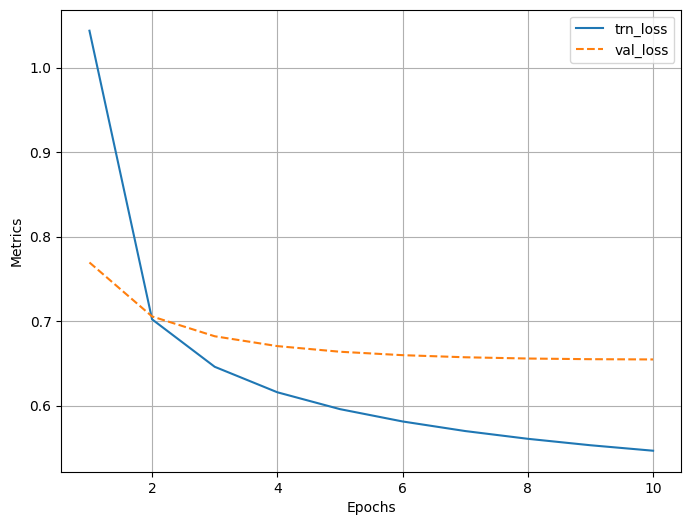

100%|██████████| 111/111 [00:00<00:00, 119.22it/s]


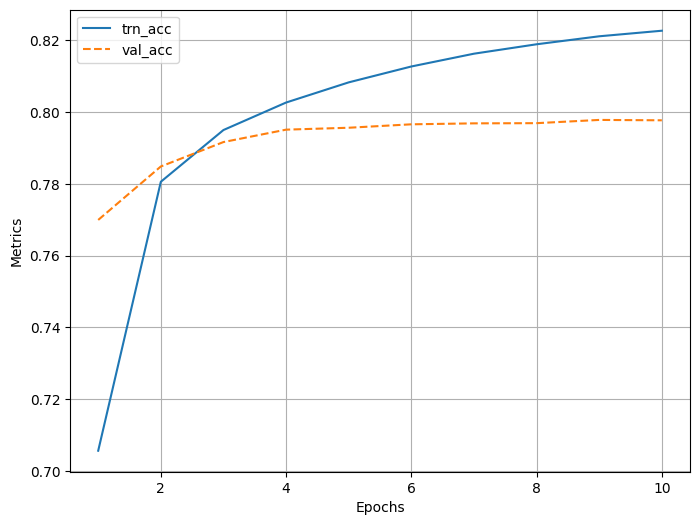

(None, None)

In [ ]:
log.plot_epochs('trn_loss,val_loss'.split(',')), log.plot_epochs('trn_acc,val_acc'.split(','))

#**VGG16(pretrained=True)**

In [ ]:
model = tv.models.vgg16(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:05<00:00, 103MB/s] 


In [ ]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
summary(model.to(device), input_size=(3, 224, 224))

In [ ]:
for name, param in model.named_parameters():
 param.requires_grad = False

In [ ]:
model.classifier[6]

Linear(in_features=4096, out_features=1000, bias=True)

In [ ]:
model.classifier[6] = nn.Linear(in_features=4096, out_features=47)

In [ ]:
model.classifier[6]

Linear(in_features=4096, out_features=47, bias=True)

In [ ]:
unfreeze_layers = [model.classifier]
for layer in unfreeze_layers:
 for param in layer.parameters():
  param.requires_grad = True

In [ ]:
print("Params to learn:")
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:

classifier.6.weight

classifier.6.bias

In [ ]:
trainer = torch.optim.Adam(params_to_update, lr=0.001)

In [ ]:
#def train(net, train_iter, test_iter, trainer, num_epochs):
model.to(device)
loss = nn.CrossEntropyLoss(reduction='mean')
num_epochs = 10
log = Report(num_epochs)
list_2_1 = []
list_2_2 = []
for epoch in range(num_epochs):
    N = len(train_iter)
    for i, (X, y) in enumerate(train_iter):
        model.train()
        if i==N: break
        X, y = X.to(device), y.to(device)
        trainer.zero_grad()
        y_hat = model(X)
        l = loss(y_hat.squeeze(), y)
        l.backward()
        trainer.step()
        train_acc_sum = (y_hat.argmax(axis=1) == y).sum().item()/ len(X)
        log.record(epoch+(i+1)/N, trn_loss=l,trn_acc=train_acc_sum, end='\r')
    list_2_1.append(l)

    N = len(test_iter)
    for i, (X, y) in enumerate(test_iter):
        model.eval()
        if i==N: break
        X, y = X.to(device), y.to(device)
#        with torch.no_grad():
        pred_tarf = model(X)
        l_test = loss(pred_tarf.squeeze(), y)
        test_acc = (model(X).argmax(axis=1) == y).sum()/ len(X)
        log.record(epoch+(i+1)/N, val_loss=l_test, val_acc=test_acc, end='\r')
    list_2_1.append(l_test)
    log.report_avgs(epoch+1)

EPOCH: 1.000  val_loss: 0.918  val_acc: 0.725  trn_acc: 0.571  trn_loss: 1.446  (863.58s - 7772.24s remaining)
EPOCH: 2.000  val_loss: 0.821  val_acc: 0.752  trn_acc: 0.618  trn_loss: 1.274  (1727.94s - 6911.74s remaining)
EPOCH: 2.991  trn_loss: 0.874  trn_acc: 0.594  (2397.31s - 5616.45s remaining)

KeyboardInterrupt: ignored

In [ ]:
print(list_2_1, list_2_2)

100%|██████████| 111/111 [00:00<00:00, 111.95it/s]


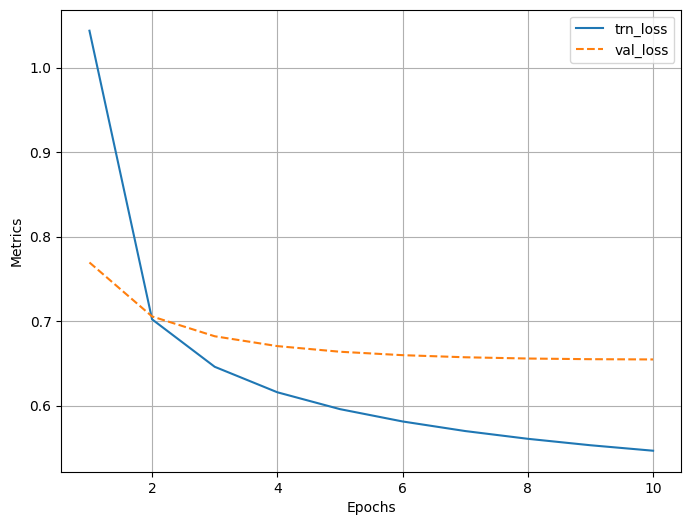

100%|██████████| 111/111 [00:00<00:00, 119.22it/s]


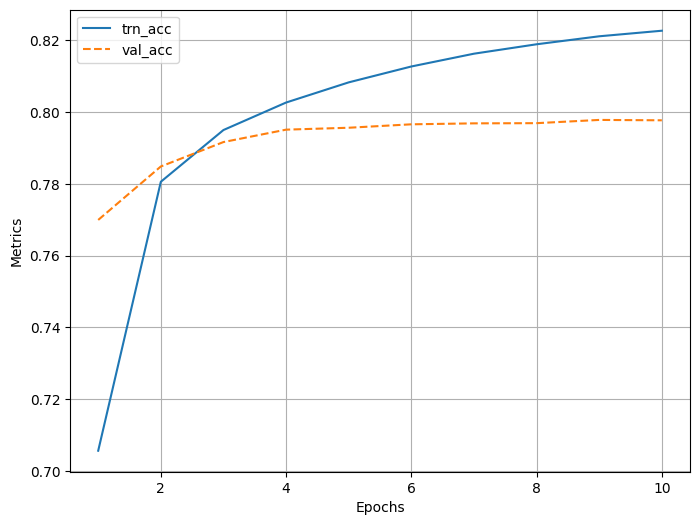

(None, None)

In [ ]:
log.plot_epochs('trn_loss,val_loss'.split(',')), log.plot_epochs('trn_acc,val_acc'.split(','))

#**Inception v3(pretrained=True)**

In [ ]:
transoforms = tv.transforms.Compose([
    tv.transforms.Grayscale(3),
    tv.transforms.Resize((299, 299)),
    tv.transforms.ToTensor()
])

train_dataset = tv.datasets.EMNIST('./EMNIST', split='balanced', train=True, transform=transoforms, download=True)
test_dataset = tv.datasets.EMNIST('./EMNIST', split='balanced', train=False, transform=transoforms, download=True)
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=32)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=32)

In [ ]:
%%capture
model = tv.models.inception_v3(pretrained=True)

In [ ]:
model

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [ ]:
summary(model.to(device), input_size=(3, 299, 299))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 149, 149]             864
       BatchNorm2d-2         [-1, 32, 149, 149]              64
       BasicConv2d-3         [-1, 32, 149, 149]               0
            Conv2d-4         [-1, 32, 147, 147]           9,216
       BatchNorm2d-5         [-1, 32, 147, 147]              64
       BasicConv2d-6         [-1, 32, 147, 147]               0
            Conv2d-7         [-1, 64, 147, 147]          18,432
       BatchNorm2d-8         [-1, 64, 147, 147]             128
       BasicConv2d-9         [-1, 64, 147, 147]               0
        MaxPool2d-10           [-1, 64, 73, 73]               0
           Conv2d-11           [-1, 80, 73, 73]           5,120
      BatchNorm2d-12           [-1, 80, 73, 73]             160
      BasicConv2d-13           [-1, 80, 73, 73]               0
           Conv2d-14          [-1, 192,

In [ ]:
for name, param in model.named_parameters():
 param.requires_grad = False

In [ ]:
model.fc

Linear(in_features=2048, out_features=1000, bias=True)

In [ ]:
model.fc = nn.Linear(in_features=2048, out_features=47)

In [ ]:
model.fc

Linear(in_features=512, out_features=47, bias=True)

In [ ]:
model

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [ ]:
unfreeze_layers = [model.fc]
for layer in unfreeze_layers:
 for param in layer.parameters():
  param.requires_grad = True

In [ ]:
print("Params to learn:")
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:

fc.weight

fc.bias

In [ ]:
trainer = torch.optim.Adam(params_to_update, lr=0.001)

In [ ]:
model.to(device)
loss = nn.CrossEntropyLoss(reduction='mean')
num_epochs = 10
log = Report(num_epochs)
list_3_1 = []
list_3_2 = []
for epoch in range(num_epochs):
    N = len(train_iter)
    for i, (X, y) in enumerate(train_iter):
        model.train()
        if i==N: break
        X, y = X.to(device), y.to(device)
        trainer.zero_grad()
        y_hat = model(X)
        l = loss(y_hat.squeeze(), y)
        l.backward()
        trainer.step()
        train_acc_sum = (y_hat.argmax(axis=1) == y).sum().item()/ len(X)
        log.record(epoch+(i+1)/N, trn_loss=l,trn_acc=train_acc_sum, end='\r')
    list_3_1.append(l)
    N = len(test_iter)
    for i, (X, y) in enumerate(test_iter):
        model.eval()
        if i==N: break
        X, y = X.to(device), y.to(device)
#        with torch.no_grad():
        pred_tarf = model(X)
        l_test = loss(pred_tarf.squeeze(), y)
        test_acc = (model(X).argmax(axis=1) == y).sum()/ len(X)
        log.record(epoch+(i+1)/N, val_loss=l_test, val_acc=test_acc, end='\r')
    list_3_1.append(l_test)
    log.report_avgs(epoch+1)

In [ ]:
print(list_3_1, list_3_2)

100%|██████████| 111/111 [00:00<00:00, 111.95it/s]


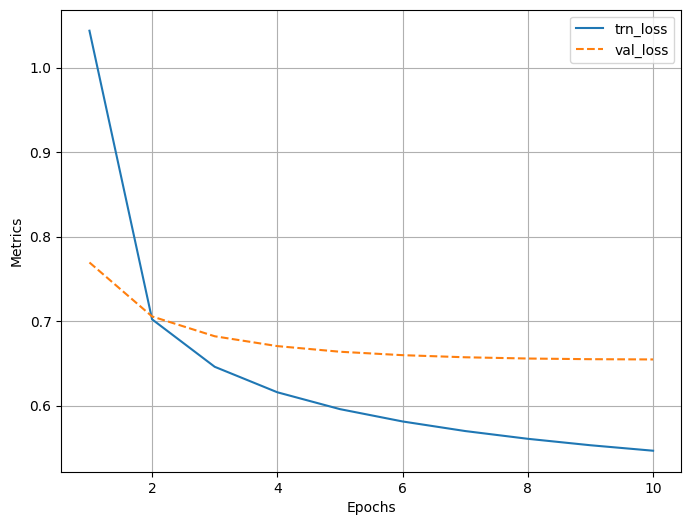

100%|██████████| 111/111 [00:00<00:00, 119.22it/s]


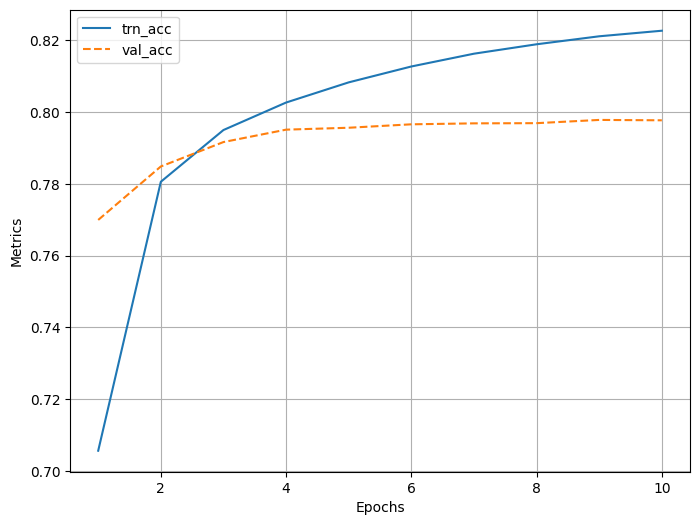

(None, None)

In [ ]:
log.plot_epochs('trn_loss,val_loss'.split(',')), log.plot_epochs('trn_acc,val_acc'.split(','))

#### ResNet

#### DenseNet

#**DenseNet 161(pretrained=True)**

In [ ]:
transoforms = tv.transforms.Compose([
    tv.transforms.Grayscale(3),
    tv.transforms.Resize((224, 224)),
    tv.transforms.ToTensor()
])

train_dataset = tv.datasets.EMNIST('./EMNIST', split='balanced', train=True, transform=transoforms, download=True)
test_dataset = tv.datasets.EMNIST('./EMNIST', split='balanced', train=False, transform=transoforms, download=True)
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=32)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=32)

In [ ]:
%%capture
model = tv.models.densenet161(pretrained=True)

In [ ]:
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [ ]:
for name, param in model.named_parameters():
 param.requires_grad = False

In [ ]:
model.classifier

Linear(in_features=2208, out_features=1000, bias=True)

In [ ]:
model.classifier = nn.Linear(in_features=2208, out_features=47)

In [ ]:
model.classifier

Linear(in_features=2048, out_features=47, bias=True)

In [ ]:
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [ ]:
unfreeze_layers = [model.classifier]
for layer in unfreeze_layers:
 for param in layer.parameters():
  param.requires_grad = True

In [ ]:
print("Params to learn:")
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:

classifier.weight

classifier.bias

In [ ]:
trainer = torch.optim.Adam(params_to_update, lr=0.001)

In [ ]:
model.to(device)
loss = nn.CrossEntropyLoss(reduction='mean')
num_epochs = 10
log = Report(num_epochs)
for epoch in range(num_epochs):
    N = len(train_iter)
    for i, (X, y) in enumerate(train_iter):
        model.train()
        if i==N: break
        X, y = X.to(device), y.to(device)
        trainer.zero_grad()
        y_hat = model(X)
        l = loss(y_hat.squeeze(), y)
        l.backward()
        trainer.step()
        train_acc_sum = (y_hat.argmax(axis=1) == y).sum().item()/ len(X)
        log.record(epoch+(i+1)/N, trn_loss=l,trn_acc=train_acc_sum, end='\r')
    N = len(test_iter)
    for i, (X, y) in enumerate(test_iter):
        model.eval()
        if i==N: break
        X, y = X.to(device), y.to(device)
#        with torch.no_grad():
        pred_tarf = model(X)
        l_test = loss(pred_tarf.squeeze(), y)
        test_acc = (model(X).argmax(axis=1) == y).sum()/ len(X)
        log.record(epoch+(i+1)/N, val_loss=l_test, val_acc=test_acc, end='\r')
    log.report_avgs(epoch+1)

100%|██████████| 111/111 [00:00<00:00, 111.95it/s]


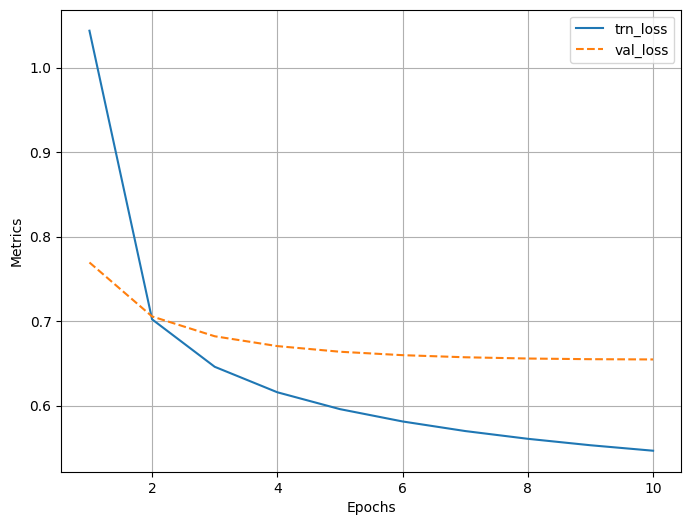

100%|██████████| 111/111 [00:00<00:00, 119.22it/s]


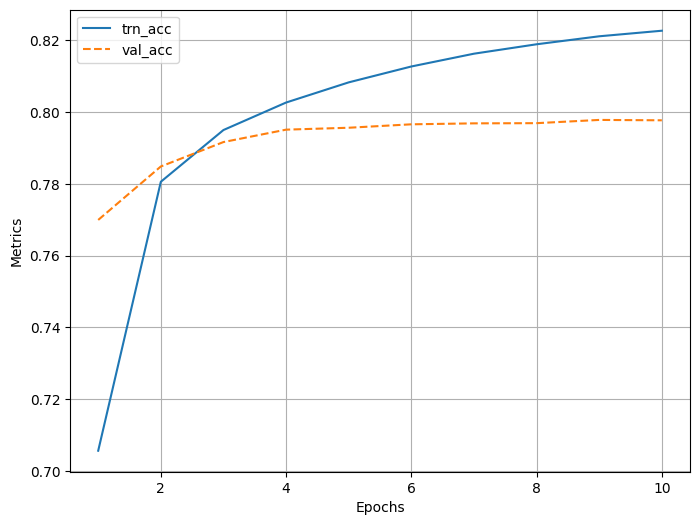

(None, None)

In [ ]:
log.plot_epochs('trn_loss,val_loss'.split(',')), log.plot_epochs('trn_acc,val_acc'.split(','))